# 01: Stable Diffusion v1.5 model exploration

In [2]:
from diffusers import StableDiffusionPipeline
import torch
from matplotlib import pyplot as plt
import cv2
import numpy as np
import torchinfo
import torchview
from torchview import draw_graph
from datasets import load_dataset_builder, load_dataset
from graphviz_anywidget import graphviz_widget

In [3]:
dataset = load_dataset("timm/mini-imagenet", split="test")

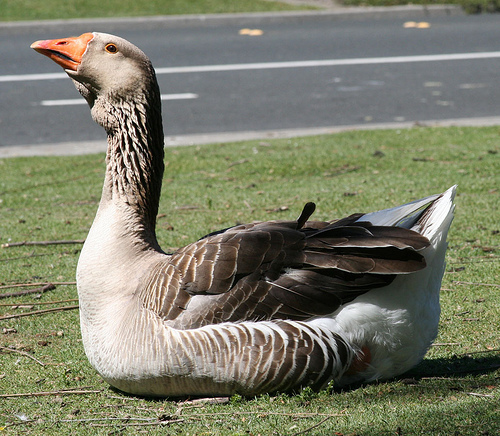

In [4]:
test_img = dataset[300]['image']
test_img

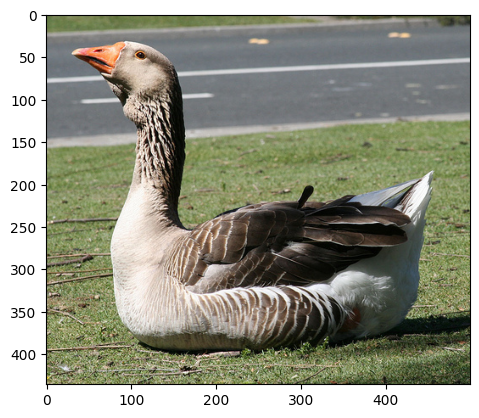

In [5]:
np_img = np.array(test_img)
plt.imshow(np_img)

## Model setup

In [6]:
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("mps")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


## Model test

In [7]:
prompt = "a photo of an astronaut riding a horse on mars"
image_pil = pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

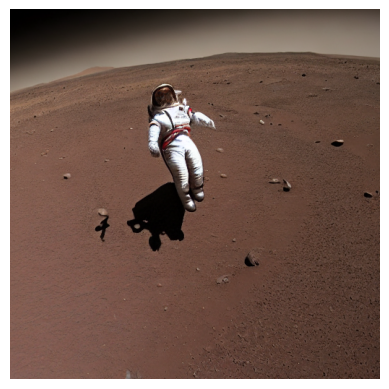

In [8]:
plt.imshow(image_pil)
plt.axis('off')
plt.show()

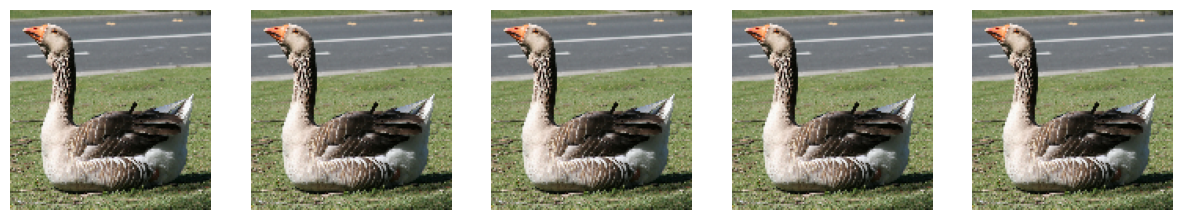

In [9]:
test_images = torch.tensor(np.array([np_img] * 5), device=pipe.device).float() # (N, H, W, C)

test_images = test_images.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

test_images = (test_images / 255.0) * 2.0 - 1.0 #Normalisation

test_images = torch.nn.functional.interpolate(test_images, size=(128, 128), mode='bilinear') # Scaling

def show_images(images: torch.Tensor):
    # denormalize from [-1, 1] to [0, 1]
    images = (images + 1.0) / 2.0
    plt.figure(figsize=(15, 15))
    for i in range(images.shape[0]):
        img = images[i].permute(1, 2, 0).cpu().numpy()  #[i]CHW -> HWC
        plt.subplot(1, images.shape[0], i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.show()

show_images(test_images)

## Exploring the architecture

### Components

In [10]:
pipe.components.keys()

dict_keys(['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder'])

### Tokenizer (CLIP)

In [11]:
pipe.tokenizer.__class__

transformers.models.clip.tokenization_clip.CLIPTokenizer

In [12]:
from transformers import CLIPTokenizer
tokenizer: CLIPTokenizer = pipe.tokenizer

In [13]:
prompt_tokens = tokenizer.encode("a goose in space", return_tensors="pt").to(pipe.device)
prompt_tokens.shape

torch.Size([1, 6])

### Prompt Encoder (CLIP)

In [14]:
pipe.text_encoder.__class__

transformers.models.clip.modeling_clip.CLIPTextModel

In [15]:
from transformers import CLIPTextModel
text_encoder: CLIPTextModel = pipe.text_encoder

In [16]:
prompt_encoded = text_encoder.forward(prompt_tokens).last_hidden_state
prompt_encoded.shape

torch.Size([1, 6, 768])

In [17]:
prompt_embeds, negative_embeds = pipe.encode_prompt(
    prompt="aaa",
    device=pipe.device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt=None
)
torch.sum(prompt_embeds), torch.sum(negative_embeds)

(tensor(-6496., device='mps:0', dtype=torch.float16, grad_fn=<SumBackward0>),
 tensor(-6432., device='mps:0', dtype=torch.float16, grad_fn=<SumBackward0>))

In [18]:
prompt_embeds, negative_embeds = pipe.encode_prompt(
    prompt="",
    device=pipe.device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt=None
)
torch.sum(prompt_embeds), torch.sum(negative_embeds)

(tensor(-6432., device='mps:0', dtype=torch.float16, grad_fn=<SumBackward0>),
 tensor(-6432., device='mps:0', dtype=torch.float16, grad_fn=<SumBackward0>))

This is an empty prompt embedding

In [19]:
negative_embeds.shape

torch.Size([1, 77, 768])

### VAE

In [20]:
pipe.components['vae']

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

#### Summary

In [21]:
torchinfo.summary(pipe.vae, depth=5)

Layer (type:depth-idx)                             Param #
AutoencoderKL                                      --
├─Encoder: 1-1                                     --
│    └─Conv2d: 2-1                                 3,584
│    └─ModuleList: 2-2                             --
│    │    └─DownEncoderBlock2D: 3-1                --
│    │    │    └─ModuleList: 4-1                   --
│    │    │    │    └─ResnetBlock2D: 5-1           295,680
│    │    │    │    └─ResnetBlock2D: 5-2           295,680
│    │    │    └─ModuleList: 4-2                   --
│    │    │    │    └─Downsample2D: 5-3            147,584
│    │    └─DownEncoderBlock2D: 3-2                --
│    │    │    └─ModuleList: 4-3                   --
│    │    │    │    └─ResnetBlock2D: 5-4           919,040
│    │    │    │    └─ResnetBlock2D: 5-5           1,181,184
│    │    │    └─ModuleList: 4-4                   --
│    │    │    │    └─Downsample2D: 5-6            590,080
│    │    └─DownEncoderBlock2D: 3-3       

In [22]:
pipe.vae.__class__

diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL

In [23]:
from diffusers import AutoencoderKL
vae: AutoencoderKL = pipe.vae

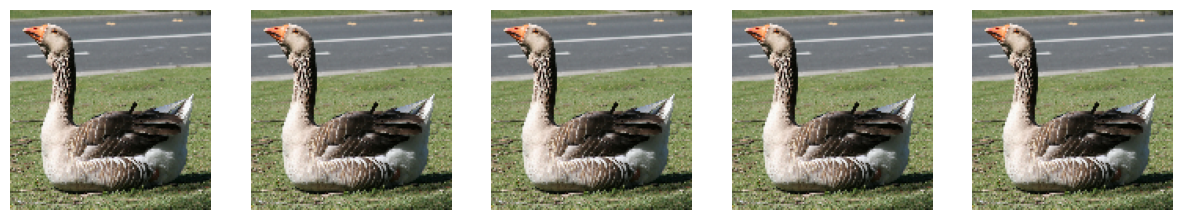

In [24]:
show_images(test_images)

In [25]:
encoded = vae.encode(test_images.half()).latent_dist.sample()
encoded_scaled = encoded * vae.config.scaling_factor # scaling for unet
print(vae.config.scaling_factor)
encoded_scaled.shape

0.18215


torch.Size([5, 4, 16, 16])

In [26]:
encoded_descaled = encoded_scaled / vae.config.scaling_factor # scaling back to decode
decoded = vae.decode(encoded_descaled).sample
decoded.shape

torch.Size([5, 3, 128, 128])

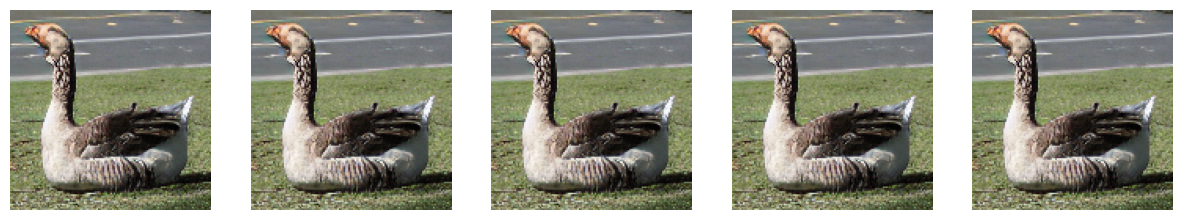

In [27]:
decoded_no_grad = decoded.detach()
show_images(decoded_no_grad.float())

### Scheduler

In [28]:
pipe.scheduler.__class__

diffusers.schedulers.scheduling_pndm.PNDMScheduler

https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm

In [29]:
from diffusers import PNDMScheduler
scheduler: PNDMScheduler = pipe.scheduler

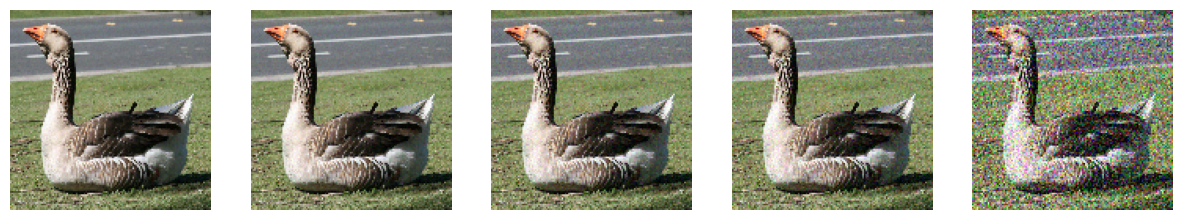

In [30]:
noise = torch.randn((1, 3, 128, 128), device=pipe.device) # noise of shape NCHW (1, C, H, W).
# N = 1 because the noise is the same for each image in the batch
timestep = torch.tensor([0, 1, 5, 10, 100], device=noise.device).int() # (N), noise intensity for each sample

#NOISING
noisy_images = scheduler.add_noise(test_images, noise, timestep)


show_images(noisy_images)

### Latent noising

In [31]:
total_steps = scheduler.config.num_train_timesteps
total_steps

1000

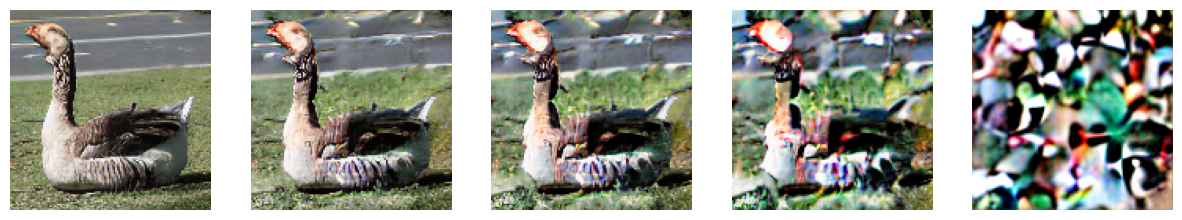

In [44]:
noise = torch.randn((1, 4, 16, 16), device=pipe.device)
timestep = torch.tensor([0, 50, 100, 200, total_steps], device=noise.device).int()
noisy_latents = scheduler.add_noise(encoded_scaled, noise, timestep)
noisy_latents_descaled = noisy_latents / vae.config.scaling_factor
noisy_decoded = vae.decode(noisy_latents_descaled.half()).sample
detached_noisy_decoded = noisy_decoded.detach()
show_images(detached_noisy_decoded.float())

### UNet

In [33]:
pipe.components['unet']

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

#### Summary

In [34]:
torchinfo.summary(pipe.unet, depth=5)

Layer (type:depth-idx)                                            Param #
UNet2DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─ModuleList: 1-4                                                 --
│    └─CrossAttnDownBlock2D: 2-4                                  --
│    │    └─ModuleList: 3-1                                       --
│    │    │    └─Transformer2DModel: 4-1                          --
│    │    │    │    └─GroupNorm: 5-1                              640
│    │    │    │    └─Conv2d: 5-2                                 102,720
│    │ 

#### Graph

In [35]:
# batch_size = 1
# height = pipe.unet.config.sample_size
# width = pipe.unet.config.sample_size
# latents_shape = (batch_size, pipe.unet.config.in_channels, height, width)
# prompt_shape = (batch_size, 77, pipe.unet.config.cross_attention_dim)
#
# dummy_latents = torch.randn(latents_shape, dtype=pipe.unet.dtype, device=pipe.device)
# dummy_context = torch.randn(prompt_shape, dtype=pipe.unet.dtype, device=pipe.device)
#
# dummy_timestep = torch.tensor([1], device=pipe.device)
#
# graph = draw_graph(
#     pipe.unet,
#     input_data=(dummy_latents, dummy_timestep, dummy_context),
#     expand_nested=True,
#     depth=2,
#     save_graph=True,
#     filename="unet_architecture"
# )
#
# graph.visual_graph.render(format="png")
# print("Graph rendered successfully.")
#
# graphviz_widget(graph.visual_graph.source)

#### Exploring the class

In [36]:
pipe.unet.__class__

diffusers.models.unets.unet_2d_condition.UNet2DConditionModel

In [37]:
from diffusers import UNet2DConditionModel
unet: UNet2DConditionModel = pipe.unet

#### Denoising pipeline

In [38]:
noisy_latents.half().shape

torch.Size([5, 4, 16, 16])

In [39]:
print(timestep.shape)
print(timestep)


torch.Size([1])
tensor([1000], device='mps:0', dtype=torch.int32)


In [40]:
prompt_encoded.half().expand(5,-1,-1).shape

torch.Size([5, 6, 768])

In [41]:
pred_noise = unet.forward(
    sample=noisy_latents.half(),
    timestep=timestep,
    encoder_hidden_states=prompt_encoded.half().expand(5,-1,-1)
).sample

pred_noise.shape

torch.Size([5, 4, 16, 16])

In [42]:
scheduler.set_timesteps(50)

# just to test the timestep is set to 50 - doesnt make much sense
pred_denoised = scheduler.step(
    model_output=pred_noise.half(),
    timestep=50,
    sample=noisy_latents.half()
).prev_sample

pred_denoised.shape

torch.Size([5, 4, 16, 16])

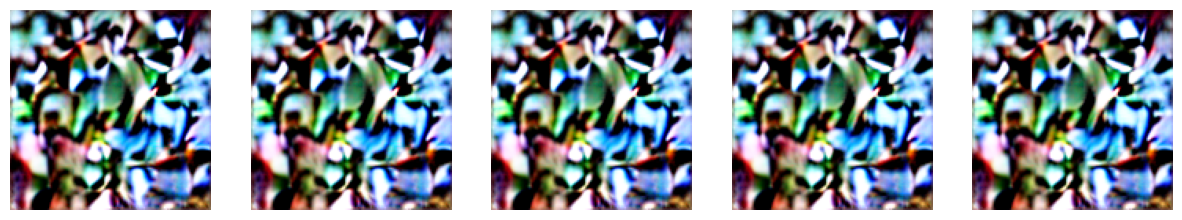

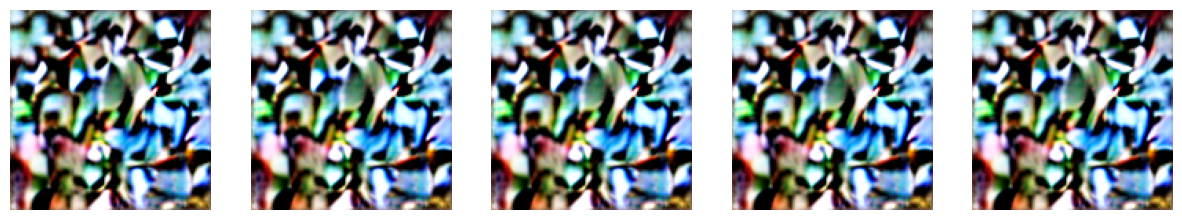

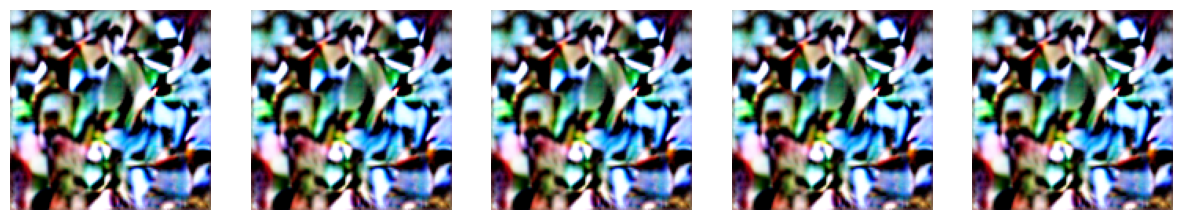

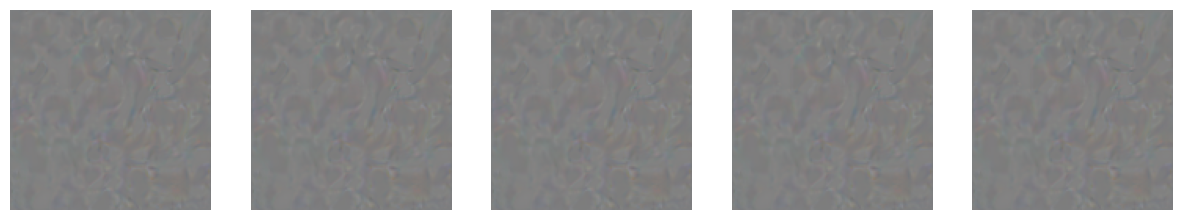

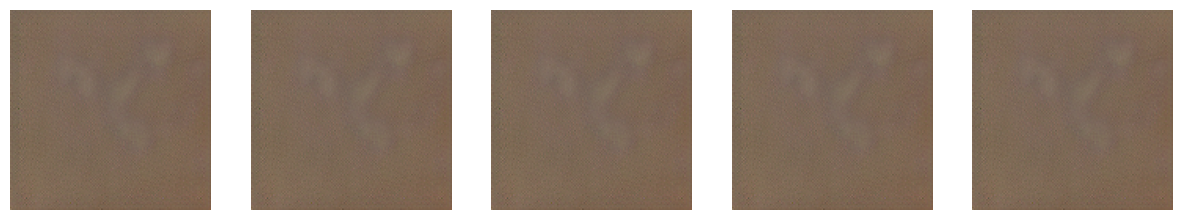

In [43]:
pred_noise_descaled = pred_noise / vae.config.scaling_factor
pred_noise_decoded = vae.decode(pred_noise_descaled.half()).sample
detached_pred_noise_decoded = pred_noise_decoded.detach()

pred_denoised_descaled = pred_denoised / vae.config.scaling_factor
pred_denoised_decoded = vae.decode(pred_denoised_descaled.half()).sample
detached_pred_denoised_decoded = pred_denoised_decoded.detach()

diff = detached_pred_denoised_decoded.float() - detached_noisy_decoded.float()

latent_diff = pred_denoised.float() - noisy_latents.float()
latent_diff_descaled = latent_diff / vae.config.scaling_factor
latent_diff_decoded = vae.decode(latent_diff_descaled.half()).sample
detached_latent_diff_decoded = latent_diff_decoded.detach()

show_images(detached_noisy_decoded.float())
show_images(detached_pred_noise_decoded.float())
show_images(detached_pred_denoised_decoded.float())
show_images(diff.float())
show_images(detached_latent_diff_decoded.float())